In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid

from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
# generate data 
n = 100
f = lambda x: .7*np.sin(5 * x) * (1 - np.tanh(x ** 2))

# precision of prior
alpha = .1

# precision of noise
s = .1
beta = 1./s**2

x = np.linspace(-1., 1., n)
t = f(x) + s * np.random.randn(n) 

In [3]:
# compute true posterior 
S = 1./(alpha + beta * np.sum(x**2))
mu = beta*S*np.sum(x*t)

# predictive distribution
t_hat = mu * x
s_hat = np.sqrt(S * x**2)

print("Mean {:.3f}, Stdv {:.3f}".format(mu, np.sqrt(S)))

Mean 0.034, Stdv 0.017


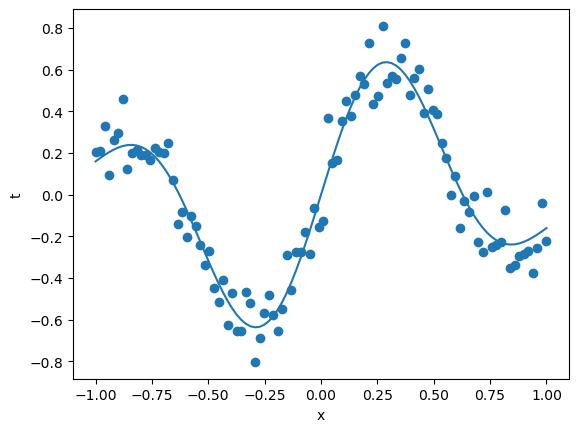

In [4]:
plt.scatter(x, t)
plt.plot(x, f(x))
# plt.fill_between(x, t_hat-s_hat, t_hat+s_hat, alpha=.5, color='C0')
plt.xlabel("x")
plt.ylabel("t")
plt.show()

In [5]:
# goal is to use a neural network to map Gaussian noise to samples from posterior parameter distribution

In [6]:
# define model that takes in unknown parameters (latent variables)
@jit
def model(x, z):
    
    a, b, c, d, e, f, g = z
    
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5 + g*x**6

# gradient of model w.r.t. parameters
grad_model = jit(jacfwd(model, 1))

# problem dimension
d = 7 

# determine shapes of weights/biases = [Wih, bih, Who, bho]
shapes = [[d, d], [d], [d, d], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.zeros(n_params)
for k1,k2,shape in zip(k_params, k_params[1:], shapes):
    if len(shape)>1:
        stdv = 1/np.sqrt(shape[-1])
    lmbda[k1:k2] = stdv*np.random.randn(k2-k1,)

# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    W1, b1, W2, b2 = reshape(lmbda)
    
    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', W1, y) + b1)
    
    # output
    z = jnp.einsum('ij,...j->...i', W2, h) + b2
    
    return z

# gradient of nn output w.r.t. parameters
grad_nn = jit(jacfwd(nn, 1))

@jit 
def inv_nn(z, lmbda):
    
    # weights and biases of nn
    W1, b1, W2, b2 = reshape(lmbda)
    
    # hidden layer
    h = jnp.einsum('ij,...j->...i', inv(W2), z - b2)

    # input 
    y = jnp.einsum('ij,...j->...i', inv(W1), jnp.arctanh(h) - b1)

    return y 
    
# gradient of nn output w.r.t. parameters
jac_nn_inv = jit(jacfwd(inv_nn, 0))

@jit
def log_abs_det(zi, lmbda):
    return jnp.log(jnp.abs(jnp.linalg.det(jac_nn_inv(zi, lmbda))))

# gradient of entropy of approximating distribution w.r.t. lmbda
grad_log_abs_det = jit(jacfwd(log_abs_det, 1))

In [7]:
y = np.random.random(size=[3, d])
y

array([[0.46743319, 0.86351983, 0.19817609, 0.88610484, 0.42475574,
        0.87567666, 0.36299249],
       [0.25124373, 0.70577568, 0.91668979, 0.41558473, 0.12851642,
        0.87314891, 0.4711106 ],
       [0.06404261, 0.58125618, 0.25858246, 0.61244385, 0.07035893,
        0.33264656, 0.26416013]])

In [8]:
# should be same as y 
inv_nn(nn(y, lmbda), lmbda)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array([[0.4674324 , 0.8635182 , 0.1981749 , 0.88610715, 0.42475647,
        0.87567466, 0.36299184],
       [0.2512429 , 0.7057746 , 0.91668636, 0.41558322, 0.12851144,
        0.8731499 , 0.47110513],
       [0.06404256, 0.5812536 , 0.25858477, 0.61244726, 0.07036091,
        0.33264494, 0.2641613 ]], dtype=float32)

In [9]:
# ELBO cost function
def cost(lmbda):
    
    # use nn to sample parameters
    y = np.random.random(size=[1000, d])
    # y = np.random.randn(1000, d)
    z = nn(y, lmbda)
    
    # evaluate model fitness 
    ELBO = alpha * np.sum(z**2) / 2. / z.shape[0] 
    for yi, zi in zip(y, z):
        ELBO -= log_abs_det(zi, lmbda) / z.shape[0]
        ELBO += beta*jnp.sum((t - model(x, zi))**2) / 2. / z.shape[0]
    
    # gradient 
    grad_nn_eval = grad_nn(y, lmbda)
    grad_ELBO = alpha * np.einsum('ni,nij->j', z, grad_nn_eval) / z.shape[0]
    for gi, zi in zip(grad_nn_eval, z):
        grad_ELBO -= grad_log_abs_det(zi, lmbda) / z.shape[0]
        grad_ELBO += beta*np.einsum('t,ti,ij->j', model(x, zi) - t, grad_model(x, zi), gi) / z.shape[0]
    
    return ELBO, grad_ELBO

def callback(xk, res=None):
    # print(cost(xk))
    print("Loss: {:.3f}".format(cost(xk)[0]))
    return True

In [10]:
res = minimize(fun=cost,
               jac=True,
               x0=lmbda,
               method='BFGS', 
               callback=callback)

lmbda = res.x

Loss: 2681.900
Loss: 1265.969
Loss: 695.171
Loss: 526.973
Loss: 421.678
Loss: 389.958
Loss: 366.959
Loss: 366.894
Loss: 338.275
Loss: 323.091
Loss: 302.320
Loss: 274.696
Loss: 232.264
Loss: 209.311
Loss: 178.654
Loss: 160.509
Loss: 147.800
Loss: 123.197
Loss: 110.725


In [11]:
# sample gaussian noise
y = np.random.random(size=[1000, d])
# y = np.random.randn(1000, d)
z = nn(y, lmbda)

In [12]:
z.shape

(1000, 7)

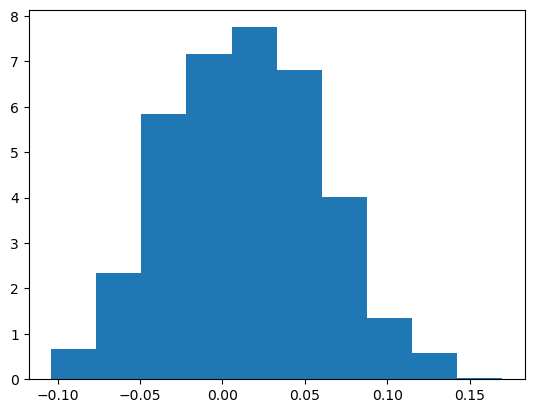

In [18]:
plt.hist(z[:, 0], density=True)
plt.show()

In [16]:
x = np.linspace(-1., 1., n)
t_samples = vmap(model, (None, 0))(x, z)
t_hat = np.mean(t_samples, 0)
s_hat = np.std(t_samples, 0)

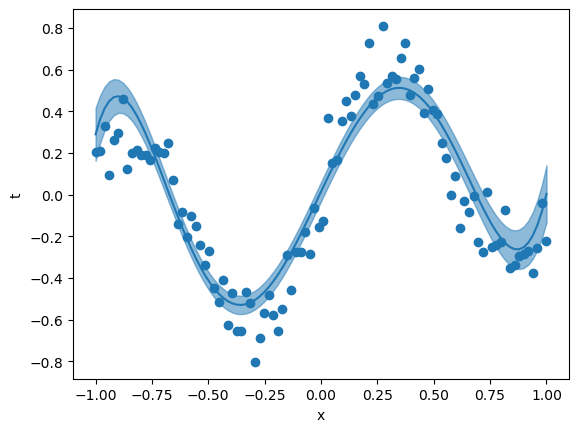

In [17]:
plt.scatter(x, t)
plt.plot(x, t_hat)
plt.fill_between(x, t_hat-s_hat, t_hat+s_hat, alpha=.5, color='C0')
plt.xlabel("x")
plt.ylabel("t")
plt.show()